# **Default Setting**

* Python: 3.6.9
* ML Framework: tensorflow-gpu 2.4.0 / tensorflow-addons 0.12.0
* CPU: AMD Ryzen 5 5600X 6-Core Processor
* GPU: GeForce RTX 3070 (8G) (CUDA 11.1)
* RAM: 32G
* Platform: Linux Ubuntu 20.04 LTS (desktop)

Install below APIs using anaconda as belows.

```
conda create -n py36 python=3.6.9
conda acitvate py36
pip3 install tensorflow-gpu=2.4.0 tensorflow-addons=0.12.0
conda install pandas, matplotlib, pydot, jupyterlab, cudatoolkit
```

And now, you can run jupyter lab (or jupyter notebook).

```
jupyter lab
```

In [1]:
%env NOTEBOOKNAME try150
%env LOCAL_DATA_PATH data
%env CHECKPOINT_PATH ckpt
%env SUBMISSION_PATH submission

env: NOTEBOOKNAME=try150
env: LOCAL_DATA_PATH=data
env: CHECKPOINT_PATH=ckpt
env: SUBMISSION_PATH=submission


In [2]:
import tensorflow as tf
import tensorflow_addons as tfa

import datetime
import glob
import os

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

print(f"tf.__version__: {tf.__version__}")
print(f"tfa.__version__: {tfa.__version__}")

tf.__version__: 2.4.0
tfa.__version__: 0.12.0


In [3]:
# If you wanna avoid below error, you need to run below codes when you start kernel.

# UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, 
# so try looking to see if a warning log message was printed above. [Op:Conv2D]

# Ref: https://blog.naver.com/vft1500/221793591386

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
# !python -V

In [5]:
# !cat /proc/cpuinfo

In [6]:
!nvidia-smi

Fri Jan  8 17:02:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 455.32.00    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Graphics Device     On   | 00000000:0A:00.0 Off |                  N/A |
|  0%   29C    P2    30W / 220W |    373MiB /  7979MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
# !df -h

In [8]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:           31Gi       1.2Gi        23Gi       9.0Mi       6.4Gi        29Gi
Swap:         2.0Gi       214Mi       1.8Gi


In [9]:
# Load the TensorBoard notebook extension.
# %load_ext tensorboard

# **Define Arguments**

In [10]:
class HParams(object):
    def __init__(self):
        # Basic
        self.seed = 42
        self.test_size = 0.2
        self.epoch = 50
        self.lr = 1e-3
        
        # Dataframe
        self.num_test_csv = 81
        self.day_split = 1
        self.day = int(48 // self.day_split) # 48
        self.inp = int(7 * self.day_split) # 7 days
        self.tar = int(2 * self.day_split) # 2 days
        
        # Dataset Pipeline
        self.w_inp = self.inp * self.day
        self.w_tar = self.tar * self.day
        self.w_shift = self.day
        self.w_stride = 1
        self.w_dr = True
        
        self.shuffle_buffer_sz = 100_000
        
        self.auto = tf.data.experimental.AUTOTUNE
        
        self.global_batch_size = 64
        
        # model
        self.num_features = 3 # DNI, DHI, TARGET
        self.num_quantile = 9
        
        self.input_shape = [self.inp, self.day, self.num_features]
        self.input_dtype = tf.float32
        self.units = 64
        self.out_steps = self.tar
        self.dropout_rate = 0.4
        
        # Remove checkpoints.
        self.max_to_keep = 3
        
        # Post-processing.
        self.epsilon = 5e-2 # almost min(df["TARGET"]) / 2
        
        
HPARAMS = HParams()

# **Load Datasets**

## **Define Preprocessing Funciton**

In [11]:
def preprocessing(
    df, 
    is_training = True
) -> pd.DataFrame:
    """Preprocess dataframes."""
    
    # Drop columns.
    df = df.drop(["Day", "Hour", "Minute", "WS", "RH", "T"], axis = 1)
    
#     if is_training:
#         max_min_dict = {
#             "DHI_MAX": np.float32(df["DHI"].max()),
#             "DHI_MIN": np.float32(df["DHI"].min()),
#             "DNI_MAX": np.float32(df["DNI"].max()),
#             "DNI_MIN": np.float32(df["DNI"].min()),

#             # Target is a relative value that means power generation efficiency, 
#             # and it is assumed to have a value between [0, 100].
#             "TARGET_MAX": np.float32(100),
#             "TARGET_MIN": np.float32(0)}

#         HPARAMS.max_min_dict = max_min_dict
    
#     # Max-min scaling.
#     for column in df.columns:
#         df[column] = (df[column] - HPARAMS.max_min_dict[f"{column}_MIN"]) /\
#             (HPARAMS.max_min_dict[f"{column}_MAX"] - HPARAMS.max_min_dict[f"{column}_MIN"])
   
#         df[column] = np.float32(df[column])
        
    return df

## **Train & Validation Dataframes**

In [12]:
df = pd.read_csv(os.path.join(os.environ["LOCAL_DATA_PATH"], "train", "train.csv"))
df.head()

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
0,0,0,0,0,0,1.5,69.08,-12,0.0
1,0,0,30,0,0,1.5,69.06,-12,0.0
2,0,1,0,0,0,1.6,71.78,-12,0.0
3,0,1,30,0,0,1.6,71.75,-12,0.0
4,0,2,0,0,0,1.6,75.20,-12,0.0


In [13]:
HPARAMS.split_len = int(df.shape[0] * (1. - HPARAMS.test_size))
HPARAMS.split_len = HPARAMS.split_len - np.mod(HPARAMS.split_len, HPARAMS.day)

tr_df = df[:HPARAMS.split_len]
vl_df = df[HPARAMS.split_len:]

tr_df = preprocessing(tr_df)
vl_df = preprocessing(vl_df, is_training = False)

tr_df.shape, vl_df.shape

((42048, 3), (10512, 3))

## **Test Dataframe**

In [14]:
ts_filenames = [os.path.join(os.environ["LOCAL_DATA_PATH"], "test", f"{i}.csv") for i in range(HPARAMS.num_test_csv)]
ts_dfs = [preprocessing(pd.read_csv(ts_filename), is_training = False) for ts_filename in ts_filenames]
ts_df = pd.concat(ts_dfs)

ts_df.shape

(27216, 3)

# **Make Dataset Pipelines**

The first batch is to bundle the tensors as input into units of a day. The operation below can guarantee that the number of sequences of tr_tensor and vl_tensor is a multiple of a day (i.e. 48), so `drop_remainder = True` is actually meaningless. However, it was added to specify the shape of the input data during the window division process (`.window(...)`)

```
args["SPLIT_LEN"] = int(df.shape[0] * (1. - args["TEST_SIZE"]))
args["SPLIT_LEN"] = args["SPLIT_LEN"] - np.mod(args["SPLIT_LEN"], args["DAY"]) # this process

tr_df = df[:args["SPLIT_LEN"]]
vl_df = df[args["SPLIT_LEN"]:]
```

It is recommended to cache the dataset after the map transformation except if this transformation makes the data too big to fit in memory. A trade-off can be achieved if your mapped function can be split in two parts: a time consuming one and a memory consuming part. In this case, you can chain your transformations like below:

```
dataset.map(time_consuming_mapping).cache().map(memory_consuming_mapping)
```

If the cache is executed after partioning the window, the amount of data loaded in the memory increases by about 9 times (=`(W_INP + W_TAR) / W_STRIDE)`. Obviously, the mapping process comsumes a lot of time, but since we have to train a model like this 9 times, it would be desirable to load it into the cache mory before the window split.

Also `cache` produce exactly the same elements during each iteration through the dataset. If you wish to randomize the iteration order, make sure to call `shuffle` after calling `cache`.

Immediately after the window is splited, the mapping function `_split_window` is called after stacking with `GLOBAL_BATCH_SIZE`. This time, the vectorized mapping function is called once and applies to a batch of sample. While the function could takes more time to execute, the overhead appear only once, improving the overall time performance.
        
*References*
   * *https://www.tensorflow.org/guide/data_performance*
   * *https://www.tensorflow.org/api_docs/python/tf/data/Dataset*

In [17]:
@tf.function
def _flat_fn_tr(x):
    return x.batch(HPARAMS.w_inp + HPARAMS.w_tar)


@tf.function
def _flat_fn_ts(x):
    return x.batch(HPARAMS.w_inp)


@tf.function
def _reshape_tr(features):
    return tf.reshape(features, (-1, HPARAMS.inp + HPARAMS.tar, HPARAMS.day, HPARAMS.num_features))


@tf.function
def _reshape_ts(features):
    return tf.reshape(features, (-1, HPARAMS.inp, HPARAMS.day, HPARAMS.num_features))


@tf.function
def _split_window_tr(features):
    """
        input:  (batch, 432, 3)
        output: (batch, 7, 48, 3), (aux: (batch, 2, 48, 2), real: (batch, 2, 48, 1))
    """
    inp, tar = tf.split(features, [HPARAMS.inp, HPARAMS.tar], axis = 1)
    _, tar = tf.split(tar, [-1, 1], axis = -1)
    
    return inp, (tar, tar)

In [18]:
# Dataframe to tensor.
tr_tensor = tf.constant(tr_df, dtype = tf.float32)
vl_tensor = tf.constant(vl_df, dtype = tf.float32)
ts_tensor = tf.constant(ts_df, dtype = tf.float32)

# Tensor to dataset.
tr_dataset = tf.data.Dataset.from_tensor_slices(tr_tensor
                    ).window(HPARAMS.w_inp + HPARAMS.w_tar, HPARAMS.w_shift, HPARAMS.w_stride, HPARAMS.w_dr).flat_map(_flat_fn_tr
                    ).cache(
                    ).shuffle(HPARAMS.shuffle_buffer_sz, reshuffle_each_iteration = True
                    ).batch(HPARAMS.global_batch_size
                    ).map(_reshape_tr, num_parallel_calls = HPARAMS.auto
                    ).map(_split_window_tr, num_parallel_calls = HPARAMS.auto
                    ).prefetch(HPARAMS.auto)
                                                
vl_dataset = tf.data.Dataset.from_tensor_slices(vl_tensor
                    ).window(HPARAMS.w_inp + HPARAMS.w_tar, HPARAMS.w_shift, HPARAMS.w_stride, HPARAMS.w_dr).flat_map(_flat_fn_tr
                    ).cache(
#                     ).shuffle(HPARAMS.shuffle_buffer_sz, reshuffle_each_iteration = True
                    ).batch(HPARAMS.global_batch_size
                    ).map(_reshape_tr, num_parallel_calls = HPARAMS.auto
                    ).map(_split_window_tr, num_parallel_calls = HPARAMS.auto
                    ).prefetch(HPARAMS.auto)

ts_dataset = tf.data.Dataset.from_tensor_slices(ts_tensor
                    ).window(HPARAMS.w_inp, HPARAMS.w_inp, 1, HPARAMS.w_dr).flat_map(_flat_fn_ts
                    ).cache(
#                     ).shuffle(HPARAMS.shuffle_buffer_sz, reshuffle_each_iteration = True
                    ).batch(HPARAMS.num_test_csv
                    ).map(_reshape_ts, num_parallel_calls = HPARAMS.auto
                    ).prefetch(HPARAMS.auto)

# Print the shapes.
print("tr_dataset:")
print(f"\tinp: {tr_dataset.element_spec[0]}")
print("\ttar:")
print(f"\t\t aux: {tr_dataset.element_spec[1][0]}")
print(f"\t\treal: {tr_dataset.element_spec[1][1]}")

print("vl_dataset:")
print(f"\tinp: {vl_dataset.element_spec[0]}")
print("\ttar:")
print(f"\t\t aux: {vl_dataset.element_spec[1][0]}")
print(f"\t\treal: {vl_dataset.element_spec[1][1]}")

print("ts_dataset:")
print(f"\tinp: {ts_dataset.element_spec}")

tr_dataset:
	inp: TensorSpec(shape=(None, 7, 48, 3), dtype=tf.float32, name=None)
	tar:
		 aux: TensorSpec(shape=(None, 2, 48, 1), dtype=tf.float32, name=None)
		real: TensorSpec(shape=(None, 2, 48, 1), dtype=tf.float32, name=None)
vl_dataset:
	inp: TensorSpec(shape=(None, 7, 48, 3), dtype=tf.float32, name=None)
	tar:
		 aux: TensorSpec(shape=(None, 2, 48, 1), dtype=tf.float32, name=None)
		real: TensorSpec(shape=(None, 2, 48, 1), dtype=tf.float32, name=None)
ts_dataset:
	inp: TensorSpec(shape=(None, 7, 48, 3), dtype=tf.float32, name=None)


## **Take Samples**

In [102]:
# for element in tr_dataset.take(1):
#     foo, (bar, qux) = element
#     print(foo.shape, bar.shape, qux.shape)

In [103]:
# for element in vl_dataset.take(1):
#     foo, (bar, qux) = element
#     print(foo.shape, bar.shape, qux.shape)

In [104]:
# for element in ts_dataset.take(1):
#     foo = element
#     print(foo.shape)

# **Define Loss Function**

Dacon defines the loss as shown below.

$$ L_\tau = maximum(\zeta\tau, \zeta(\tau-1)) $$

However, [the pinball loss of tensorflow-addons](https://www.tensorflow.org/addons/api_docs/python/tfa/losses/pinball_loss) is implemented as follows.

$$ L_\tau = \begin{cases} \zeta\tau & \text{ if } \zeta \geq 0 \\ -\zeta(1-\tau)=\zeta(\tau-1) & \text{ if } \zeta < 0 \end{cases}$$

The description of the symbols used in is as follows.

* $\zeta$ : y_true - y_pred
* $\tau$ : Quantile values in \[0.1, 0.2, ..., 0.9\]
* $L_\tau$ : Pinball loss function with $\tau$

The two formulas seem intuitively different, but if you actually divide the interval, you can see that they are the same. However, in experience, it seems to force an underforecast when the evaluation expression of dacon is $\tau=0.1, 0.2$. In fact, for $\tau=0.1, 0.2$, the prediction (blue lines) in the target models mostly overlaps the label (yellow lines) or lies below the graph.

# **Create Network**

## **Autoregressive-ConvLSTM2D Model**

In [33]:
def create_AR_ConvLSTM2D(
    model_name, 
    units = 32, 
    out_steps = 2,
    dropout_rate = 0.4,
) -> tf.keras.Model:
    """Create AR-ConvLSTM2D Model."""
    
    convlstm2d = tf.keras.layers.ConvLSTM2D(
        units, 3, padding = "same", dropout = dropout_rate, return_state = True,
        kernel_regularizer = tf.keras.regularizers.L2(1e-2))
    reshape = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = 1), name = "expand_timestamp_dim")
    predict_delta = tf.keras.layers.TimeDistributed(tf.keras.Sequential([
        tf.keras.layers.SpatialDropout1D(dropout_rate),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units, activation = "relu"),
        tf.keras.layers.Dense(1, kernel_initializer = tf.keras.initializers.Zeros())], name = "predict_delta"))
    add = tf.keras.layers.Add(name = "residual_add")
    outputs = []
    
    # Entry flow.
    model_input = tf.keras.layers.Input(shape = HPARAMS.input_shape, dtype = HPARAMS.input_dtype)
    
    x = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = -1), name = "expand_channel_dim")(model_input)
    x = tf.keras.layers.TimeDistributed(tf.keras.Sequential([
        tf.keras.layers.Conv2D(units, 3, padding = "same", activation = "relu"),
        tf.keras.layers.BatchNormalization()], name = "stem"))(x)
    
    # warmup
    residual_seed = tf.keras.layers.Lambda(lambda x: x[:, -1, :, -1:], name = "residual_seed")(model_input)
    outputs.append(residual_seed)
    
    x, *state = convlstm2d(x)
    outputs.append(predict_delta(x))
    
    # Middle flow.
    for _ in range(1, out_steps):
        x = reshape(x)
        x, *state = convlstm2d(x, initial_state = state, training = False)
        outputs.append(predict_delta(x))
        
    # Exit flow.
    x = tf.keras.layers.Lambda(lambda x: tf.stack(x, axis = 1), name = "stack_outputs")(outputs)
    x = tf.keras.layers.Lambda(lambda x: tf.math.cumsum(x, axis = 1)[:, 1:], name = "cumulative_delta_sum")(x)
    
    # Naming.
    aux = tf.keras.layers.Lambda(lambda x: x, name = "aux")(x)
    real = tf.keras.layers.Lambda(lambda x: x, name = "real")(x)
    
    return tf.keras.Model(
        inputs = model_input,
        outputs = [aux, real],
        name = model_name)

In [34]:
tmp = create_AR_ConvLSTM2D(
    "tmp", 
    units = HPARAMS.units, 
    out_steps = HPARAMS.out_steps,
    dropout_rate = HPARAMS.dropout_rate)

tmp.summary()

Model: "tmp"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           [(None, 7, 48, 3)]   0                                            
__________________________________________________________________________________________________
expand_channel_dim (Lambda)     (None, 7, 48, 3, 1)  0           input_28[0][0]                   
__________________________________________________________________________________________________
time_distributed_55 (TimeDistri (None, 7, 48, 3, 64) 896         expand_channel_dim[0][0]         
__________________________________________________________________________________________________
conv_lst_m2d_27 (ConvLSTM2D)    [(None, 48, 3, 64),  295168      time_distributed_55[0][0]        
                                                                 expand_timestamp_dim[0][0]     

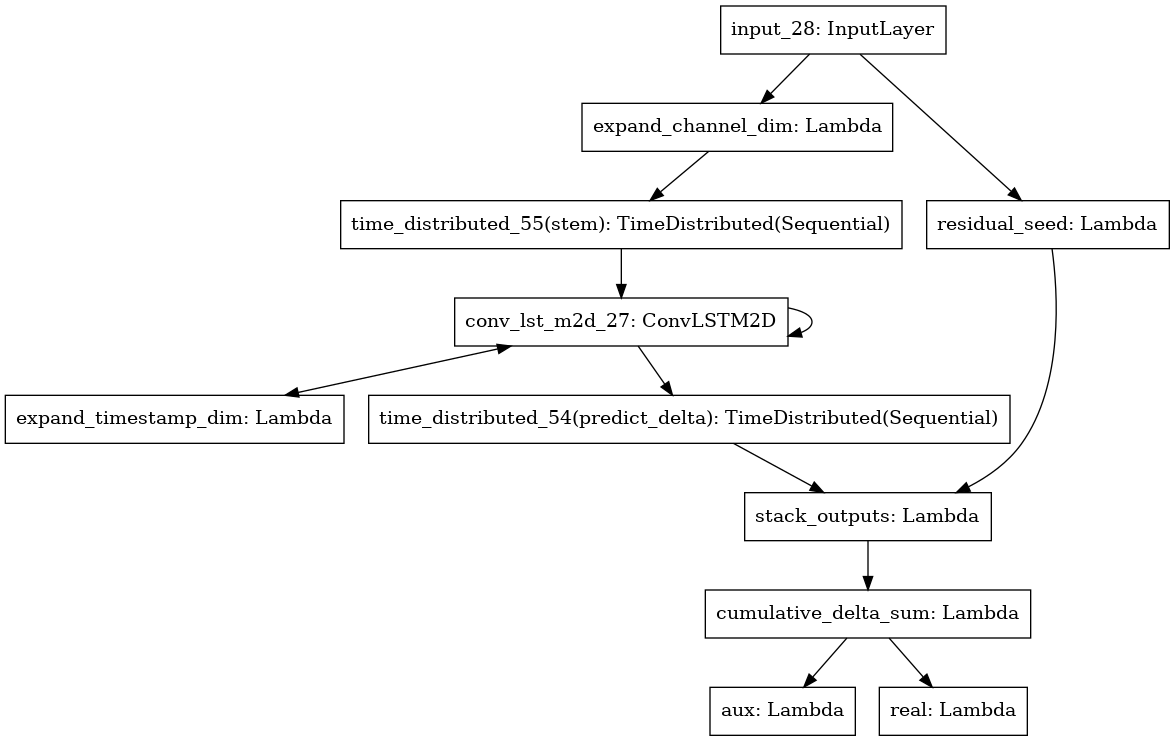

In [35]:
tf.keras.utils.plot_model(tmp, show_layer_names = True, show_shapes = False)

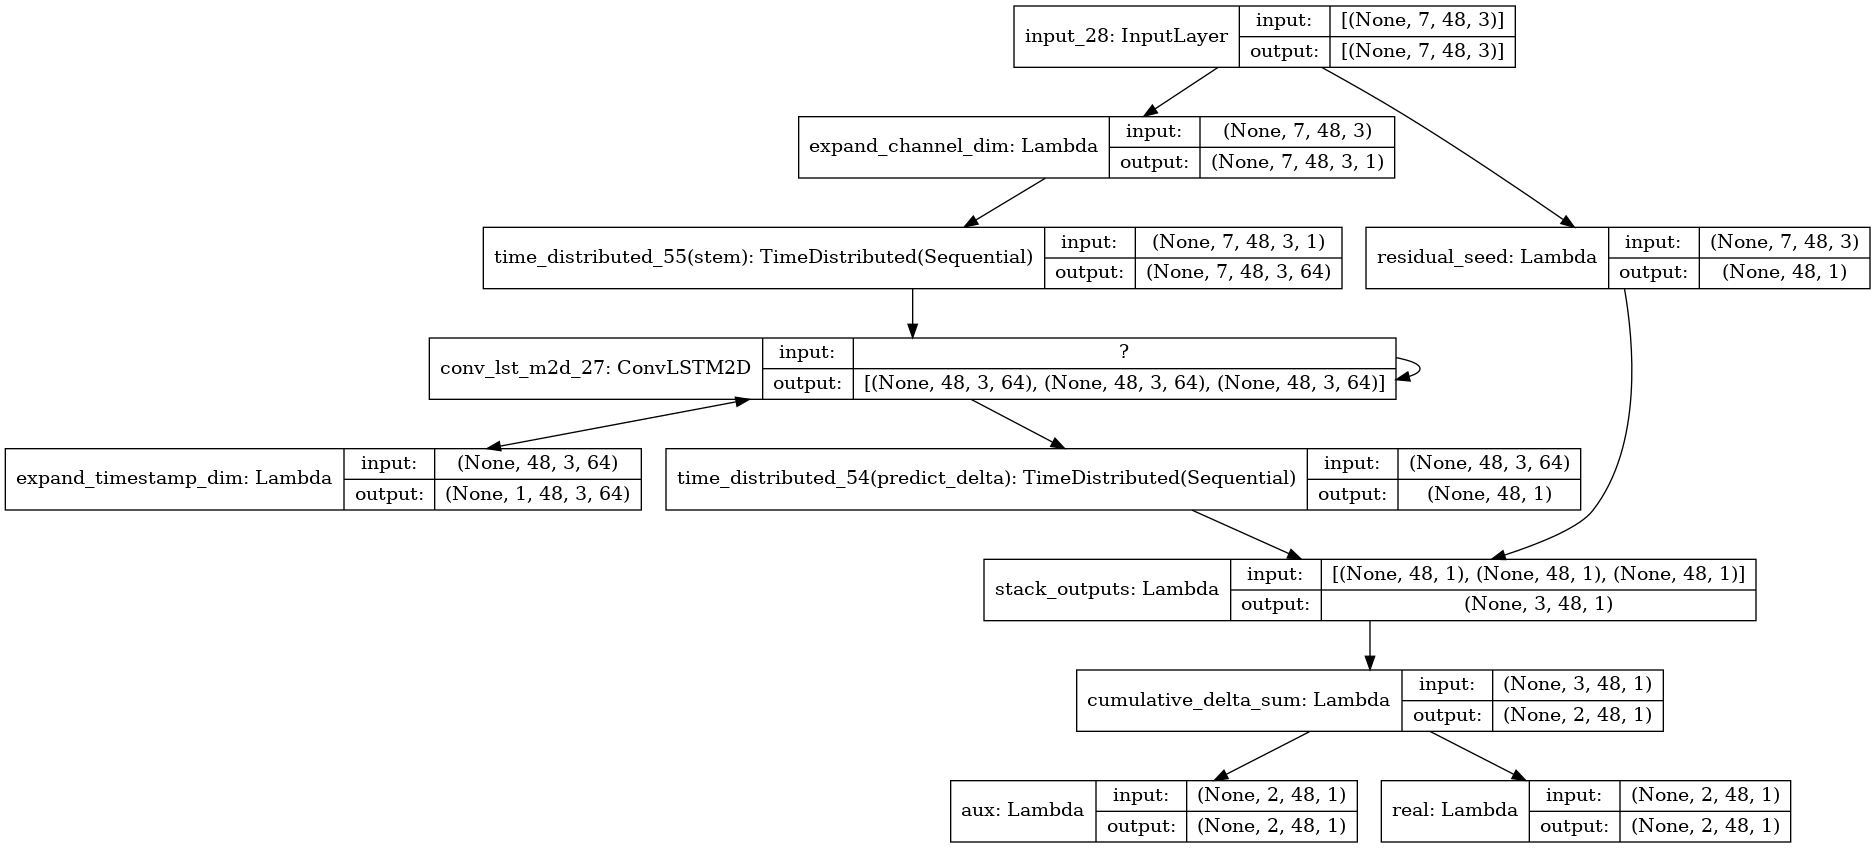

In [36]:
tf.keras.utils.plot_model(tmp, show_shapes = True)

In [37]:
del tmp

# **Compile and Fit**

In [38]:
def get_callbacks(
    model_name: str
) -> list:
    """Get checkpoint and tensorboard callbacks."""
    
    # Checkpoint callback.
    ckpt_path = os.path.join(
        os.environ["CHECKPOINT_PATH"], os.environ["NOTEBOOKNAME"], 
        model_name, "cp-{epoch:03d}-{val_real_loss:.6f}.ckpt")
    ckpt_dir = os.path.dirname(ckpt_path)
    os.makedirs(ckpt_dir, exist_ok = True)
    
    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        ckpt_path, verbose = 0, monitor = "val_real_loss", save_weights_only = True, save_best_only = True)
    
    # TensorBoard callback.
    log_dir = os.path.join(
        "logs", "fit", os.environ["NOTEBOOKNAME"], datetime.datetime.now().strftime(f"{model_name}-%Y%m%d-%H%M%S"))
    tb_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 1)
    
    return [cp_callback, tb_callback]
    

def compile_and_fit(
    model, 
    tau, 
    tr_dataset, 
    vl_dataset, 
    epochs,
    lr,
    verbose = 0, 
) -> dict:
    """Compile and fit the model."""
    
    model.compile(
        loss = [
            tfa.losses.PinballLoss(tau = 0.1 if tau < 0.5 else 0.9), 
            tfa.losses.PinballLoss(tau = tau)],
        loss_weights = [0.2, 1.0],
        optimizer = tf.keras.optimizers.Adam(lr))
    
    print(f"Model {model.name}...")

    history = model.fit(
        tr_dataset,
        validation_data = vl_dataset,
        epochs = epochs,
        verbose = verbose,
        callbacks = get_callbacks(model.name))

    return history

In [39]:
%%time

histories = {}

for tau in np.arange(0.1, 1, 0.1):
    model = create_AR_ConvLSTM2D(
        model_name = f"P{tau:.1f}", 
        units = HPARAMS.units,
        out_steps = HPARAMS.out_steps,
        dropout_rate = HPARAMS.dropout_rate)
    
    history = compile_and_fit(
        model, 
        tau, 
        tr_dataset, 
        vl_dataset, 
        HPARAMS.epoch,
        HPARAMS.lr,
        verbose = 0)
    
    histories[model.name] = history
    del model # for save memories

Model P0.1...
Model P0.2...
Model P0.3...
Model P0.4...
Model P0.5...
Model P0.6...
Model P0.7...
Model P0.8...
Model P0.9...
CPU times: user 10min 26s, sys: 25.1 s, total: 10min 51s
Wall time: 7min 41s


In [ ]:
# %tensorboard --logdir logs/fit --host jupyter-server --port 6006

## **Make Clean Checkpoints**

In [40]:
%%time

ckpt_folders = sorted(glob.glob(os.path.join(os.environ["CHECKPOINT_PATH"], os.environ["NOTEBOOKNAME"], "P*")))

num_rm_files = 0
rm_files_sz = 0 # bytes

for f in ckpt_folders:
    # 7 files must be located in ckpt_folders. (latest 3 ckpt, it's index and checkpoint file)
    assert len(os.listdir(f)) >= (1 + HPARAMS.max_to_keep * 2), f"Checkpoints in {f} is less then 3 (max_to_keep)."
    
    rm_files = [os.path.join(f, i) for i in sorted(os.listdir(f))[1:-2*HPARAMS.max_to_keep]] # [1:-6]
    num_rm_files += len(rm_files)
    rm_files_sz += sum([os.path.getsize(rm_file) for rm_file in rm_files])
    
    _ = [os.remove(rm_file) for rm_file in rm_files]
    
print(f"{num_rm_files} files removed.")
print(f"{rm_files_sz / 2**20:.2f}MB saved.")

196 files removed.
346.74MB saved.
CPU times: user 0 ns, sys: 24.6 ms, total: 24.6 ms
Wall time: 24.1 ms


# **Visualize**

## **Plot Histories**

In [41]:
def draw_histories(
    histories: dict,
):
    """Draw 9 histories in one plot."""
    
    assert len(histories.keys()) == HPARAMS.num_quantile
    
    plt.figure(figsize = (18, 14), facecolor = "white", dpi = 96)

    for model_name, history in histories.items():
        pos = int(model_name.split(".")[-1])
        plt.subplot(3, 3, pos)
                
#         plt.plot(history.epoch, history.history["aux_loss"], c = "r", label = "aux_loss")
        plt.plot(history.epoch, history.history["real_loss"], c = "r", ls = "--", label = "real_loss")
#         plt.plot(history.epoch, history.history["val_aux_loss"], c = "navy", label = "val_aux_loss")
        plt.plot(history.epoch, history.history["val_real_loss"], c = "navy", ls = "--", label = "val_real_loss")
    
        plt.legend(loc = "upper left")
        plt.title(model_name, fontsize = 20)
        plt.xlabel("Epoch")
        plt.ylabel("Pinball Loss")
    
        plt.grid(True)
        
    plt.tight_layout()
    plt.show()

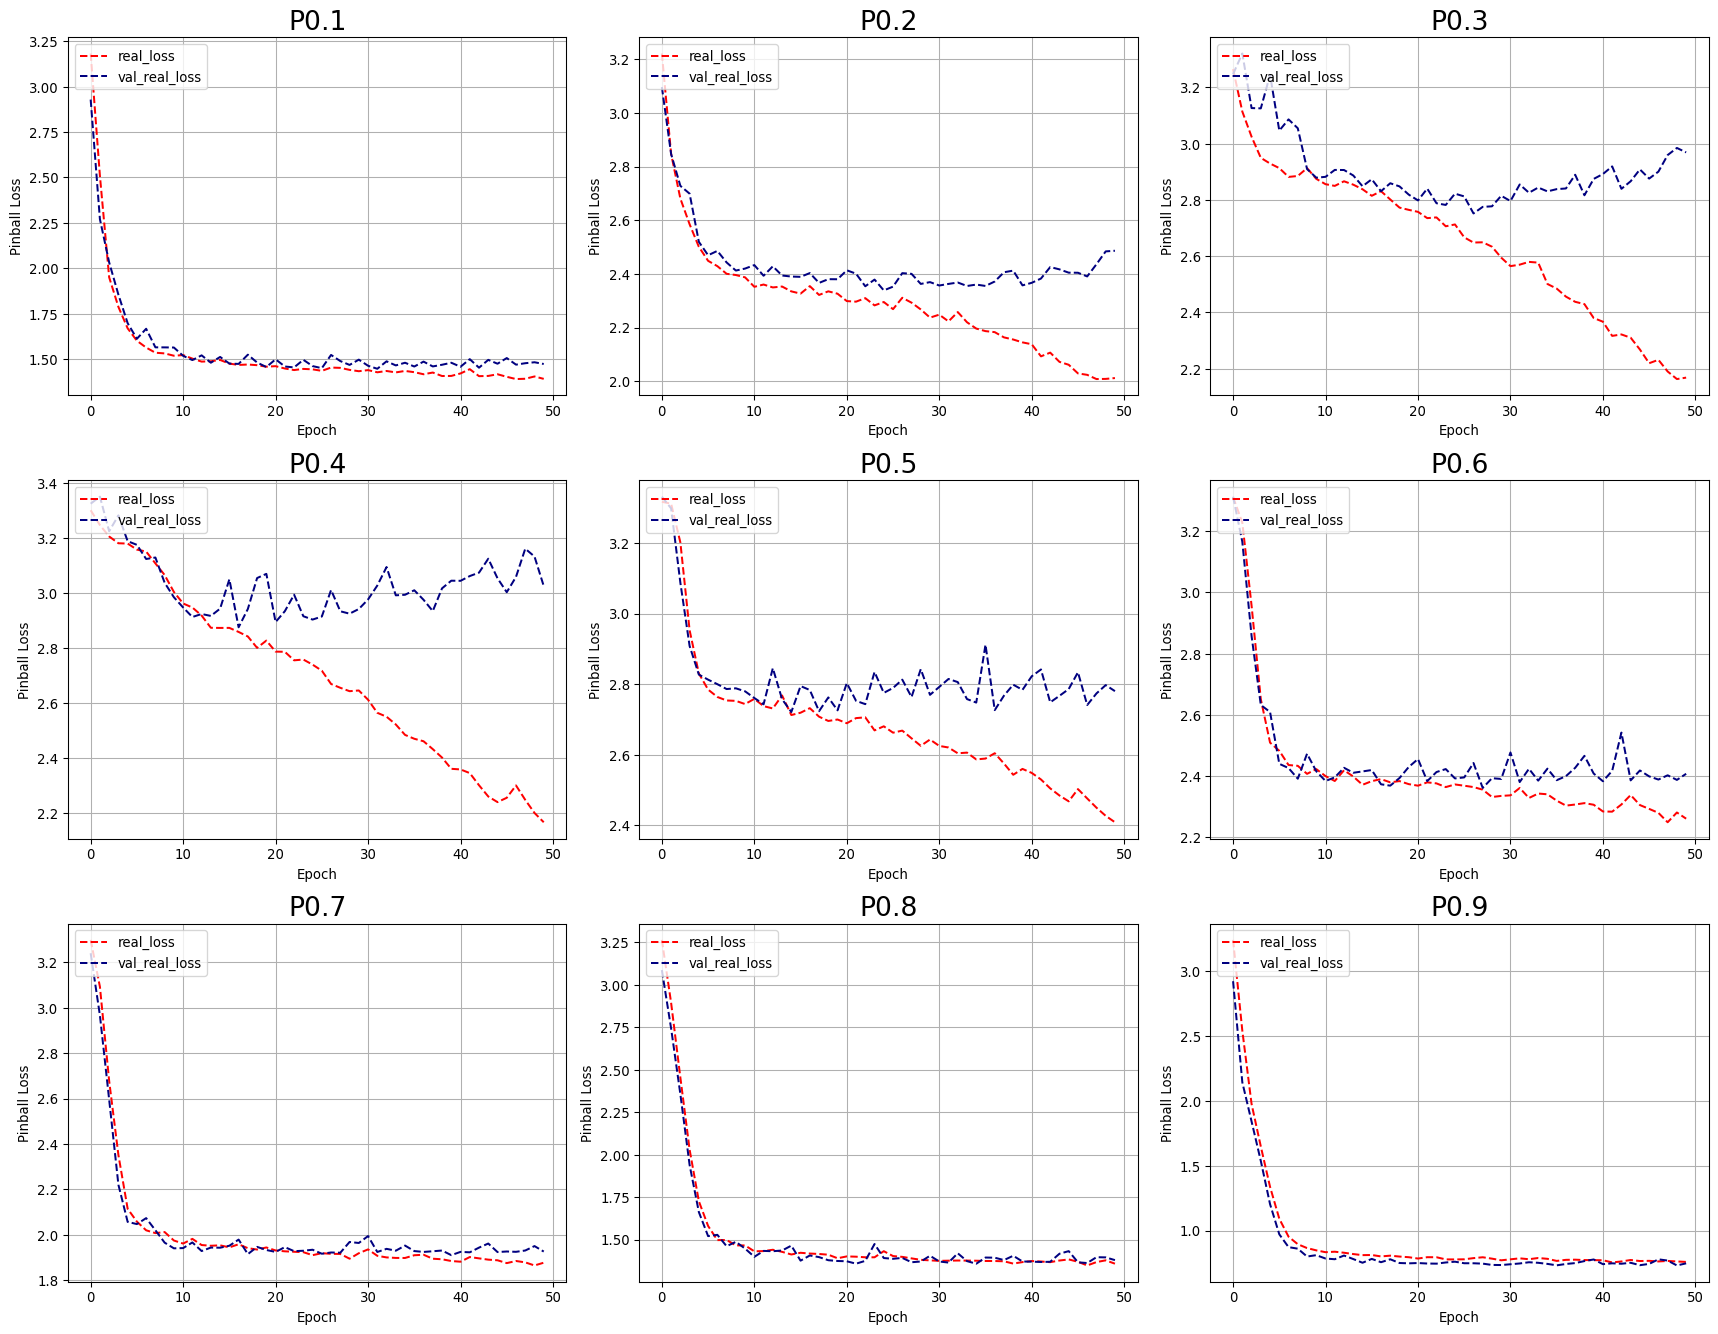

In [42]:
draw_histories(histories)

## **Target Model Prediction**

In [43]:
def load_latest_models(
    ckpt_folders: list,
) -> list:
    """Load latest weights of target model from saved ckeckpoints."""   
    
    models = []
    val_losses = []
    
    for f in ckpt_folders:
        latest = tf.train.latest_checkpoint(f)
        print(f"Load latest checkpoints: {latest}...")
        
        model_name = latest.split(os.path.sep)[-2] # ckpt/[notebookname]/P0.1/...
        val_loss = np.float32(latest.split(os.path.sep)[-1].split("-")[2][:8])

        # Define a new AR-LSTM model and load checkpoints.
        model = create_AR_ConvLSTM2D(model_name = model_name, units = 64)

        ckpt = tf.train.Checkpoint(model)
        ckpt.restore(latest).expect_partial()
        models.append(model)
        
        val_losses.append(val_loss)
        
    return models, val_losses


def draw_pred(
    inputs, 
    y_preds, 
    y_true, 
    save_fig = False,
):
    """Draw the predictions and labels."""
    
    plt.figure(figsize = (14, 4 * HPARAMS.num_quantile), facecolor = "white")
    
    for i, (y_pred, tau) in enumerate(zip(y_preds, np.arange(0.1, 1, 0.1))):
        plt.subplot(9, 1, i + 1)
        
        plt.plot(np.arange(len(inputs)), inputs, lw = 1.5, label = "Inputs")
        plt.plot(np.arange(len(inputs), len(inputs) + len(y_pred), 1), y_pred, marker = "o", lw = 1.5, label = "Predictions")
        plt.plot(np.arange(len(inputs), len(inputs) + len(y_true), 1), y_true, marker = "X", lw = 1.5, label = "Label")
    
        plt.title(f"Target Model T{tau:.1f}")
        plt.xlabel("Time [day]")
        plt.ylabel("Target")
        plt.ylim([-0.08, max(y_true) * 1.1])
        plt.legend()

        plt.xticks(
            np.arange(0, HPARAMS.w_inp + HPARAMS.w_tar + 1, HPARAMS.day), 
            [f"D+{i}" for i in np.arange(HPARAMS.inp + HPARAMS.tar + 1)])
        plt.grid(True)
        
    plt.tight_layout()
    
    if save_fig:
        plt.savefig(os.path.join("pngs", f"{os.environ['NOTEBOOKNAME']}.png"), dpi = 96)
        
    plt.show()

Load latest checkpoints: ckpt/try150/P0.1/cp-032-1.446209.ckpt...
Load latest checkpoints: ckpt/try150/P0.2/cp-025-2.338464.ckpt...
Load latest checkpoints: ckpt/try150/P0.3/cp-027-2.751867.ckpt...
Load latest checkpoints: ckpt/try150/P0.4/cp-017-2.875996.ckpt...
Load latest checkpoints: ckpt/try150/P0.5/cp-015-2.720975.ckpt...
Load latest checkpoints: ckpt/try150/P0.6/cp-028-2.360399.ckpt...
Load latest checkpoints: ckpt/try150/P0.7/cp-040-1.910592.ckpt...
Load latest checkpoints: ckpt/try150/P0.8/cp-035-1.357654.ckpt...
Load latest checkpoints: ckpt/try150/P0.9/cp-049-0.731195.ckpt...
Averaged Validation Loss: 2.0548


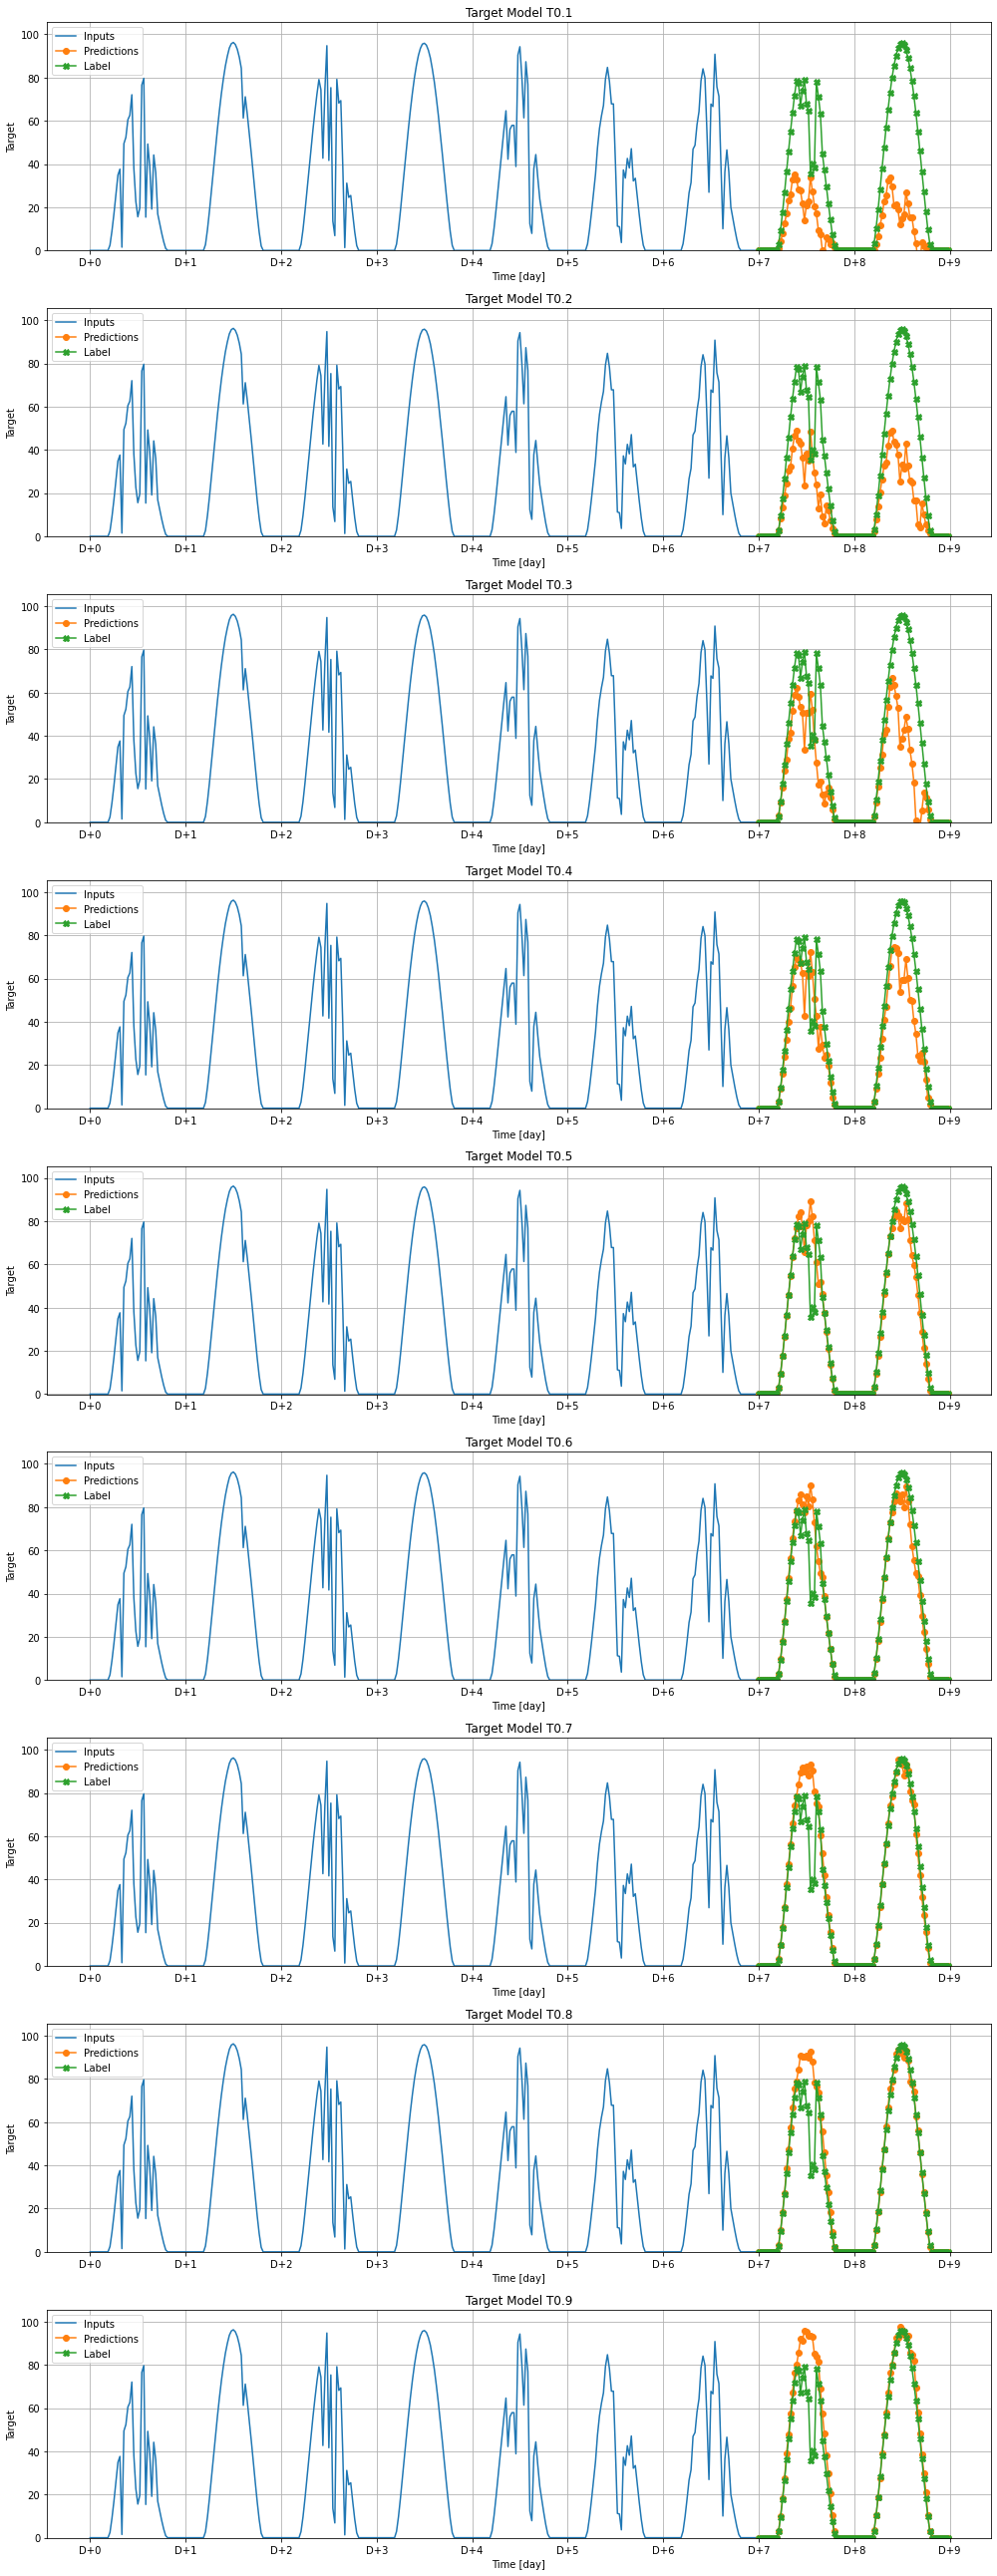

In [44]:
# Restore latest models from saved checkpoints.
ckpt_folders = sorted(glob.glob(os.path.join(os.environ["CHECKPOINT_PATH"], os.environ["NOTEBOOKNAME"], "P*")))
models, val_losses = load_latest_models(ckpt_folders)

print(f"Averaged Validation Loss: {np.mean(val_losses):.4f}")

# Now, unbatch the dataset to predict only one sequences (i.e. 7 days).
unbatched_vl_dataset = vl_dataset.unbatch().batch(1)

for t in unbatched_vl_dataset.take(1):
    x, (_, r_y) = t # inp, aux_tar, real_tar
    
    draw_pred(
        inputs = vl_tensor[:HPARAMS.w_inp, -1], # not x
        y_preds = [tf.reshape(model.predict(x)[-1], (-1, )).numpy() for model in models],
        y_true = tf.reshape(r_y, (-1, )))

# **Make Submissions**

In [28]:
%%time
# Restore latest models from saved checkpoints.
ckpt_folders = sorted(glob.glob(os.path.join(os.environ["CHECKPOINT_PATH"], os.environ["NOTEBOOKNAME"], "P*")))
models, _ = load_latest_models(ckpt_folders)

# Predict the test datasets.
# We need to drop auxiliary outputs and squeeze dimensions (i.e. [batch, 96, 1] => [batch, 96]).
preds = [np.array(tf.reshape(model.predict(ts_dataset)[-1], (-1, ))) for model in models]

Load latest checkpoints: ckpt/try150/P0.1/cp-022-1.439103.ckpt...
Load latest checkpoints: ckpt/try150/P0.2/cp-019-2.349480.ckpt...
Load latest checkpoints: ckpt/try150/P0.3/cp-022-2.781380.ckpt...
Load latest checkpoints: ckpt/try150/P0.4/cp-019-2.874854.ckpt...
Load latest checkpoints: ckpt/try150/P0.5/cp-035-2.718861.ckpt...
Load latest checkpoints: ckpt/try150/P0.6/cp-021-2.368839.ckpt...
Load latest checkpoints: ckpt/try150/P0.7/cp-026-1.901245.ckpt...
Load latest checkpoints: ckpt/try150/P0.8/cp-026-1.341194.ckpt...
Load latest checkpoints: ckpt/try150/P0.9/cp-049-0.716001.ckpt...
CPU times: user 3.54 s, sys: 54.1 ms, total: 3.59 s
Wall time: 3.54 s


In [29]:
submission = pd.read_csv(os.path.join(os.environ["LOCAL_DATA_PATH"], "sample_submission.csv"), index_col = "id")
submission.head()

,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
id,,,,,,,,,
0.csv_Day7_0h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv_Day7_0h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv_Day7_1h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv_Day7_1h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv_Day7_2h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
for column, pred in zip(submission.columns, preds):
    foo = np.reshape(pred, (-1,))
    foo = np.where(foo < HPARAMS.epsilon, 0, foo) # clip by value
    
    submission[column] = foo

In [31]:
submission.head()

,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
id,,,,,,,,,
0.csv_Day7_0h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv_Day7_0h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv_Day7_1h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv_Day7_1h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv_Day7_2h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
submission.to_csv(os.path.join(os.environ["SUBMISSION_PATH"], f"{os.environ['NOTEBOOKNAME']}_submission.csv"))